# Drug classification

**Credit: [AITS cainvas](http://cainvas.ai-tech.systems/) authors**

![](https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/drugs.gif)

Training a deep learning model to prescribe a drug based on the patient's data.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.layers import Dense
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import random
import matplotlib.pyplot as plt

# Dataset

The datatset is a CSV file with the features regarding a patient that affects drug prescriptions like age, sex, BP level, cholestrol, and sodium-potassium ratio and the corresponding drug prescribes in each case.

In [2]:
df = pd.read_csv('https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/drug200.csv')
df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


In [3]:
df['Drug'].value_counts()

DrugY    91
drugX    54
drugA    23
drugB    16
drugC    16
Name: Drug, dtype: int64

This is an unbalanced dataset.

# Preprocessing

## Balancing the dataset

In order to balance the dataset, there are two options,

* upsampling - resample the values to make their count equal to the class label with the higher count (here, 1655).
* downsampling - pick n samples from each class label where n = number of samples in class with least count (here, 176)

Here, we will be upsampling.

In [4]:
categories = np.unique(df.Drug.to_list())
df_balanced = pd.DataFrame()

for i in range(len(categories)):
    # separating into individual dataframes, one for each class 
    dfi = df[df['Drug'] == categories[i]]
    # resampling
    dfi = dfi.sample(91, replace = True)
    # appending all to one to form a final balanced dataframe
    df_balanced = df_balanced.append(dfi)

df_balanced['Drug'].value_counts()

drugC    91
DrugY    91
drugB    91
drugA    91
drugX    91
Name: Drug, dtype: int64

## Categorical variables

The 'sex' column does not define a range and thus is one-hot encoded while changing from a categorical variable to a numerical attribute

In [5]:
dfx = pd.get_dummies(df_balanced[df_balanced.columns[:-1]], drop_first = True, columns = ['Sex'])
dfx

,Age,BP,Cholesterol,Na_to_K,Sex_M
91,41,HIGH,NORMAL,15.156,1
75,26,LOW,NORMAL,20.909,1
164,16,HIGH,NORMAL,19.007,1
13,74,LOW,HIGH,20.942,0
25,28,HIGH,NORMAL,18.809,0
...,...,...,...,...,...
127,35,NORMAL,NORMAL,7.845,1
181,59,NORMAL,HIGH,13.884,0
159,34,LOW,NORMAL,12.923,0
43,23,NORMAL,HIGH,12.260,1


In [6]:
print("Values in BP column:", np.unique(dfx['BP']))
print("Values in Cholesterol column:", np.unique(dfx['Cholesterol']))

Values in BP column: ['HIGH' 'LOW' 'NORMAL']
Values in Cholesterol column: ['HIGH' 'NORMAL']


The values in the columns Cholesterol and BP represent range as seen by the values above.

In [7]:
le_bp = LabelEncoder()
le_bp.fit(['LOW', 'NORMAL', 'HIGH'])
dfx['BP'] = le_bp.transform(dfx['BP'], )
print("BP classes:", le_bp.classes_)

le_ch = LabelEncoder()
le_ch.fit(['NORMAL', 'HIGH'])
dfx['Cholesterol'] = le_ch.transform(dfx['Cholesterol'])
print("Cholesterol classes:", le_ch.classes_)

print(dfx)

BP classes: ['HIGH' 'LOW' 'NORMAL']
Cholesterol classes: ['HIGH' 'NORMAL']
     Age  BP  Cholesterol  Na_to_K  Sex_M
91    41   0            1   15.156      1
75    26   1            1   20.909      1
164   16   0            1   19.007      1
13    74   1            0   20.942      0
25    28   0            1   18.809      0
..   ...  ..          ...      ...    ...
127   35   2            1    7.845      1
181   59   2            0   13.884      0
159   34   1            1   12.923      0
43    23   2            0   12.260      1
37    39   1            1   13.938      1

[455 rows x 5 columns]



Since this is a classification problem, the output of the model which is now as an integer should be one-hot encoded.

In [8]:
df_cat = pd.get_dummies(df_balanced['Drug'])
df_cat

,DrugY,drugA,drugB,drugC,drugX
91,1,0,0,0,0
75,1,0,0,0,0
164,1,0,0,0,0
13,1,0,0,0,0
25,1,0,0,0,0
...,...,...,...,...,...
127,0,0,0,0,1
181,0,0,0,0,1
159,0,0,0,0,1
43,0,0,0,0,1


In [9]:
# defining the input and output columns to separate the dataset in the later cells.

input_columns = dfx.columns.to_list()
output_columns = df_cat.columns.to_list()

print("Number of input columns: ", len(input_columns))
#print("Input columns: ", ', '.join(input_columns))

print("Number of output columns: ", len(output_columns))
#print("Output columns: ", ', '.join(output_columns))

Number of input columns:  5
Number of output columns:  5


In [10]:
for i in output_columns:
    dfx[i] = df_cat[i]

del df_cat

dfx

,Age,BP,Cholesterol,Na_to_K,Sex_M,DrugY,drugA,drugB,drugC,drugX
91,41,0,1,15.156,1,1,0,0,0,0
75,26,1,1,20.909,1,1,0,0,0,0
164,16,0,1,19.007,1,1,0,0,0,0
13,74,1,0,20.942,0,1,0,0,0,0
25,28,0,1,18.809,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
127,35,2,1,7.845,1,0,0,0,0,1
181,59,2,0,13.884,0,0,0,0,0,1
159,34,1,1,12.923,0,0,0,0,0,1
43,23,2,0,12.260,1,0,0,0,0,1


## Train test split

In [11]:
# Splitting into train, val and test set -- 80-10-10 split

# First, an 80-20 split
train_df, val_test_df = train_test_split(dfx, test_size = 0.2, random_state = 13)

# Then split the 20% into half
val_df, test_df = train_test_split(val_test_df, test_size = 0.5, random_state = 13)

print("Number of samples in...")
print("Training set: ", len(train_df))
print("Validation set: ", len(val_df))
print("Testing set: ", len(test_df))

Number of samples in...
Training set:  364
Validation set:  45
Testing set:  46


In [12]:
# Splitting into X (input) and y (output)

Xtrain, ytrain = np.array(train_df[input_columns]), np.array(train_df[output_columns])

Xval, yval = np.array(val_df[input_columns]), np.array(val_df[output_columns])

Xtest, ytest = np.array(test_df[input_columns]), np.array(test_df[output_columns])

## Scaling the values

In [13]:
# Each feature has a different range. 
# Using min_max_scaler to scale them to values in the range [0,1].

min_max_scaler = MinMaxScaler()

# Fit on training set alone
Xtrain = min_max_scaler.fit_transform(Xtrain)

# Use it to transform val and test input
Xval = min_max_scaler.transform(Xval)
Xtest = min_max_scaler.transform(Xtest)

# Model

In [14]:
model = Sequential([
    Dense(1024, activation = 'relu', input_shape = Xtrain[0].shape),
    Dense(512, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(len(output_columns), activation = 'softmax')
])

cb = [EarlyStopping(monitor = 'val_loss', patience=8, restore_best_weights=True)]

In [15]:
model.compile(optimizer=Adam(0.01), loss=CategoricalCrossentropy(), metrics=['accuracy'])

history = model.fit(Xtrain, ytrain, validation_data = (Xval, yval), epochs=64, callbacks=cb)

Epoch 1/64
12/12 [==============================] - 0s 13ms/step - loss: 1.2915 - accuracy: 0.4588 - val_loss: 1.0577 - val_accuracy: 0.6000
Epoch 2/64
12/12 [==============================] - 0s 3ms/step - loss: 0.7581 - accuracy: 0.6896 - val_loss: 0.7546 - val_accuracy: 0.6444
Epoch 3/64
12/12 [==============================] - 0s 3ms/step - loss: 0.4894 - accuracy: 0.8049 - val_loss: 0.7814 - val_accuracy: 0.6889
Epoch 4/64
12/12 [==============================] - 0s 3ms/step - loss: 0.4375 - accuracy: 0.8544 - val_loss: 0.6606 - val_accuracy: 0.8444
Epoch 5/64
12/12 [==============================] - 0s 3ms/step - loss: 0.5359 - accuracy: 0.8187 - val_loss: 0.2804 - val_accuracy: 0.8889
Epoch 6/64
12/12 [==============================] - 0s 3ms/step - loss: 0.3168 - accuracy: 0.9038 - val_loss: 0.1936 - val_accuracy: 0.9111
Epoch 7/64
12/12 [==============================] - 0s 3ms/step - loss: 0.1425 - accuracy: 0.9588 - val_loss: 0.1256 - val_accuracy: 0.9333
Epoch 8/64
12/12 [=

In [16]:
model.evaluate(Xtest, ytest)

2/2 [==============================] - 0s 1ms/step - loss: 0.0039 - accuracy: 1.0000


[0.0039459397085011005, 1.0]

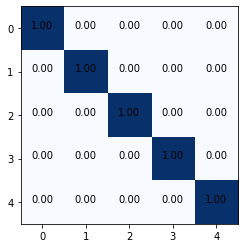

In [17]:
cm = confusion_matrix(np.argmax(ytest, axis = 1), np.argmax(model.predict(Xtest), axis = 1))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

for i in range(cm.shape[1]):
    for j in range(cm.shape[0]):
        plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="black")


plt.imshow(cm, cmap=plt.cm.Blues)

It is important to keep the accuracy extremely high (100%) as chances cannot be taken with a patient's medication.

# Plotting the metrics

In [18]:
def plot(history, variable, variable1):
    plt.plot(range(len(history[variable])), history[variable])
    plt.plot(range(len(history[variable1])), history[variable1])
    plt.title(variable)
    plt.legend([variable, variable1])

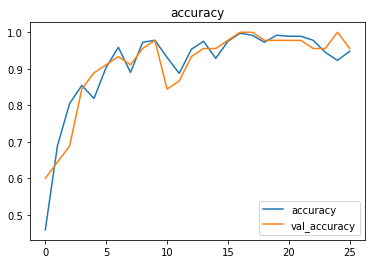

In [19]:
plot(history.history, "accuracy", "val_accuracy")

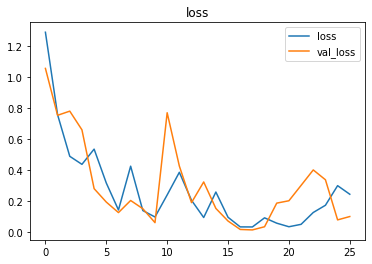

In [20]:
plot(history.history, "loss", "val_loss")

# Prediction

In [21]:
gender = ['M', 'F']

def print_sample(x):
    print("\nSample:")
    sample = np.array(test_df)[x]
    print("Age :", sample[0])
    print("Sex :", gender[int(sample[4])])
    print("Na to K ratio :", sample[3])
    print("BP :", le_bp.classes_[int(sample[1])])
    print("Cholesterol :", le_ch.classes_[int(sample[2])])
    print()

In [22]:
# pick random test data sample from one batch
x = random.randint(0, len(Xtest) - 1)

print_sample(x)

output = model.predict(Xtest[x].reshape(1, -1))    # getting output; input shape (256, 256, 3) --> (1, 256, 256, 3)
pred = np.argmax(output[0])    # finding max
print("Predicted: ", output_columns[pred])    # Picking the label from class_names base don the model output

output_true = np.array(ytest)[x]

print("True: ", output_columns[np.argmax(output_true)])
print("Probability: ", output[0][pred])


Sample:
Age : 19.0
Sex : M
Na to K ratio : 13.312999999999999
BP : HIGH
Cholesterol : HIGH

Predicted:  drugA
True:  drugA
Probability:  1.0


# deepC

In [23]:
model.save('drug.h5')

!deepCC drug.h5

[INFO]
Reading [keras model] 'drug.h5'
[SUCCESS]
Saved 'drug.onnx'
[INFO]
Reading [onnx model] 'drug.onnx'
[INFO]
Model info:
  ir_vesion : 4
  doc       : 
[WARNING]
[ONNX]: terminal (input/output) dense_input's shape is less than 1. Changing it to 1.
[WARNING]
[ONNX]: terminal (input/output) dense_4's shape is less than 1. Changing it to 1.
WARN (GRAPH): found operator node with the same name (dense_4) as io node.
[INFO]
Running DNNC graph sanity check ...
[SUCCESS]
Passed sanity check.
[INFO]
Writing C++ file 'drug_deepC/drug.cpp'
[INFO]
deepSea model files are ready in 'drug_deepC/' 
[RUNNING COMMAND]
g++ -std=c++11 -O3 -fno-rtti -fno-exceptions -I. -I/opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/include -isystem /opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/packages/eigen-eigen-323c052e1731 drug_deepC/drug.cpp -o drug_deepC/drug.exe
[RUNNING COMMAND]
size "drug_deepC/drug.exe"
   text	   data	    bss	    dec

In [24]:
# pick random test data sample from one batch
x = random.randint(0, len(Xtest) - 1)

np.savetxt('sample.data', Xtest[x])    # xth sample into text file

# run exe with input
!drug_deepC/drug.exe sample.data

# show predicted output
nn_out = np.loadtxt('deepSea_result_1.out')

print_sample(x)

pred = np.argmax(nn_out)    # finding max
print("Predicted: ", output_columns[pred])    # Picking the label from class_names base don the model output

output_true = np.array(ytest)[x]

print("True: ", output_columns[np.argmax(output_true)])
print("Probability: ", nn_out[pred])

reading file sample.data.
writing file deepSea_result_1.out.

Sample:
Age : 19.0
Sex : M
Na to K ratio : 13.312999999999999
BP : HIGH
Cholesterol : HIGH

Predicted:  drugA
True:  drugA
Probability:  1.0
